In [26]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Connect to database (correct path)
con = duckdb.connect("../db/netflix.db")

print("Connected to DuckDB!")


Connected to DuckDB!


In [27]:
df_logs = con.execute("SELECT * FROM logs LIMIT 10;").df()
df_logs


,user_id,genre,show,start_time,end_time,duration_min
0,254be1d3-166e-48ba-9d79-7e72c4718065,Thriller,Money Heist,2025-11-27 10:21:16,2025-11-27 11:00:16,39
1,ed42e9d3-603d-4b59-861e-858c934afa5a,Thriller,Mindhunter,2025-11-26 12:23:21,2025-11-26 12:39:21,16
2,77cf8270-6124-4d00-8275-9ef6b5ab23f3,Horror,The Haunting,2025-11-28 17:07:16,2025-11-28 17:42:16,35
3,b63019fa-c65f-469b-acee-5798acc582e5,Thriller,Money Heist,2025-11-28 08:26:00,2025-11-28 08:48:00,22
4,93b07e8e-87d5-4645-b997-ea8138a2c83e,Sci-Fi,Stranger Things,2025-11-29 23:19:47,2025-11-30 00:04:47,45
5,e6576cc0-d236-4df7-85ca-c9e627aac00d,Comedy,Friends,2025-11-25 19:57:29,2025-11-25 20:35:29,38
6,1e5ebaea-e47b-44bf-9984-6dd77cd93566,Sci-Fi,Stranger Things,2025-11-29 09:50:54,2025-11-29 10:44:54,54
7,1b76d9f6-baab-4b12-b718-cd4f2b4bd30a,Horror,The Haunting,2025-11-30 05:20:05,2025-11-30 06:31:05,71
8,13bb167f-1173-4a86-8203-c32d1c7fe7e8,Thriller,You,2025-11-29 16:22:26,2025-11-29 17:12:26,50
9,fdd47a63-66ef-481f-9f99-505e2c97f5f1,Comedy,Friends,2025-11-29 08:05:57,2025-11-29 09:12:57,67


In [28]:
con.execute("""
SELECT 
    COUNT(*) AS total_logs,
    COUNT(DISTINCT user_id) AS total_users,
    MIN(start_time) AS earliest_log,
    MAX(start_time) AS latest_log
FROM logs;
""").df()


,total_logs,total_users,earliest_log,latest_log
0,5000,5000,2025-11-25 10:11:44,2025-12-02 10:09:47


In [29]:
evening_genres = con.execute("""
SELECT 
    genre,
    COUNT(*) AS views
FROM logs
WHERE EXTRACT(HOUR FROM start_time) BETWEEN 19 AND 23
GROUP BY genre
ORDER BY views DESC;
""").df()

evening_genres


,genre,views
0,Sci-Fi,158
1,Action,153
2,Horror,152
3,Comedy,145
4,Thriller,145
5,Drama,144
6,Romance,129


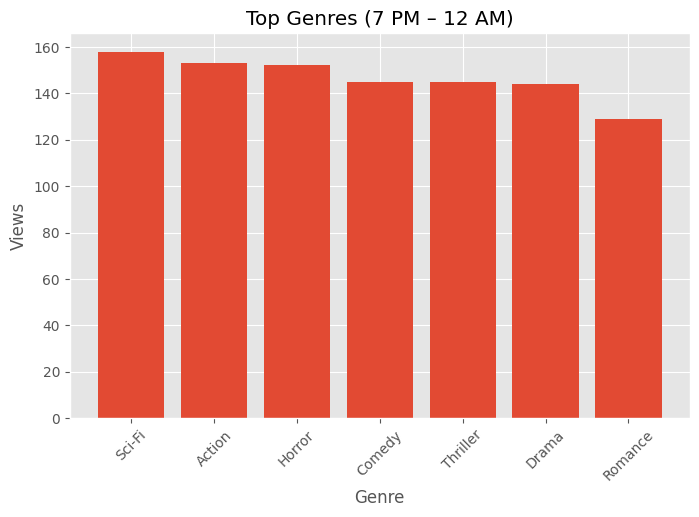

In [30]:
plt.figure(figsize=(8,5))
plt.bar(evening_genres['genre'], evening_genres['views'])
plt.title("Top Genres (7 PM – 12 AM)")
plt.xlabel("Genre")
plt.ylabel("Views")
plt.xticks(rotation=45)
plt.show()


In [31]:
avg_session = con.execute("""
SELECT ROUND(AVG(duration_min), 2) AS average_session_minutes
FROM logs;
""").df()

avg_session


,average_session_minutes
0,47.89


In [32]:
binge = con.execute("""
SELECT 
    "show" AS show_name,
    COUNT(*) AS binge_sessions
FROM logs
WHERE duration_min > 45
GROUP BY show_name
ORDER BY binge_sessions DESC
LIMIT 10;
""").df()

binge


,show_name,binge_sessions
0,Mindhunter,157
1,Vikings,142
2,Black Mirror,137
3,Narcos,136
4,The Office,131
5,Friends,130
6,Fear Street,128
7,Brooklyn 99,128
8,Extraction,127
9,Ozark,125


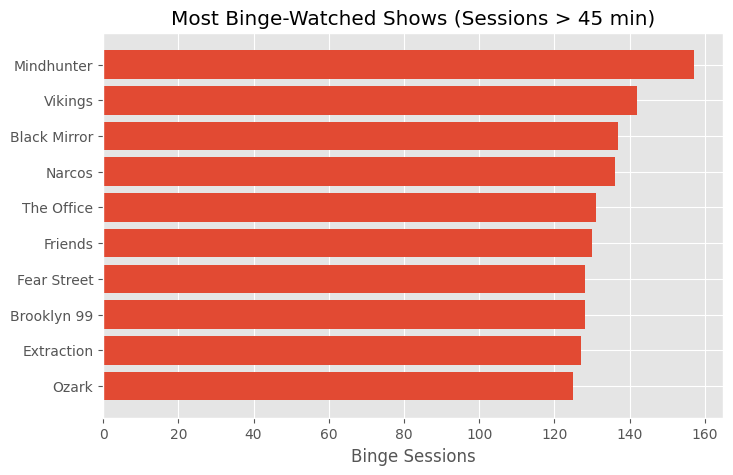

In [33]:
plt.figure(figsize=(8,5))
plt.barh(binge['show_name'], binge['binge_sessions'])
plt.title("Most Binge-Watched Shows (Sessions > 45 min)")
plt.xlabel("Binge Sessions")
plt.gca().invert_yaxis()
plt.show()


In [34]:
hourly = con.execute("""
SELECT 
    EXTRACT(HOUR FROM start_time) AS hour,
    genre,
    COUNT(*) AS views
FROM logs
GROUP BY hour, genre
ORDER BY hour;
""").df()

hourly_pivot = hourly.pivot(index="hour", columns="genre", values="views").fillna(0)
hourly_pivot


genre,Action,Comedy,Drama,Horror,Romance,Sci-Fi,Thriller
hour,,,,,,,
0,26,32,30,34,34,21,37
1,28,33,43,28,30,35,30
2,27,32,25,29,32,33,28
3,40,30,46,22,31,35,46
4,41,26,26,23,32,28,32
5,27,33,23,24,42,40,45
6,28,26,22,28,28,26,28
7,27,31,31,31,43,37,32
8,26,21,21,32,37,22,35


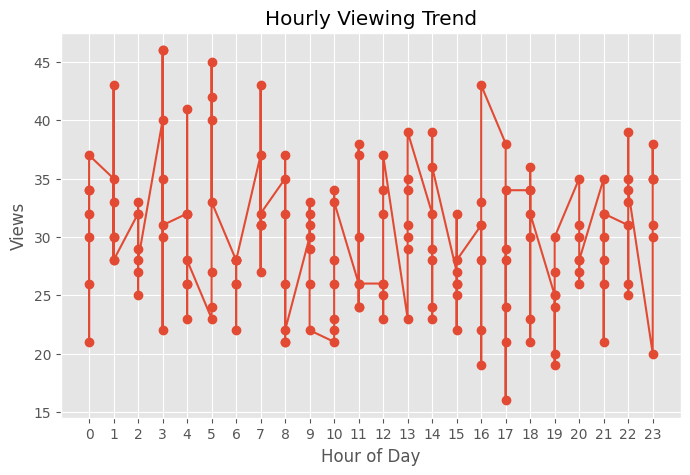

In [35]:
plt.figure(figsize=(8,5))
plt.plot(hourly['hour'], hourly['views'], marker='o')
plt.title("Hourly Viewing Trend")
plt.xlabel("Hour of Day")
plt.ylabel("Views")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


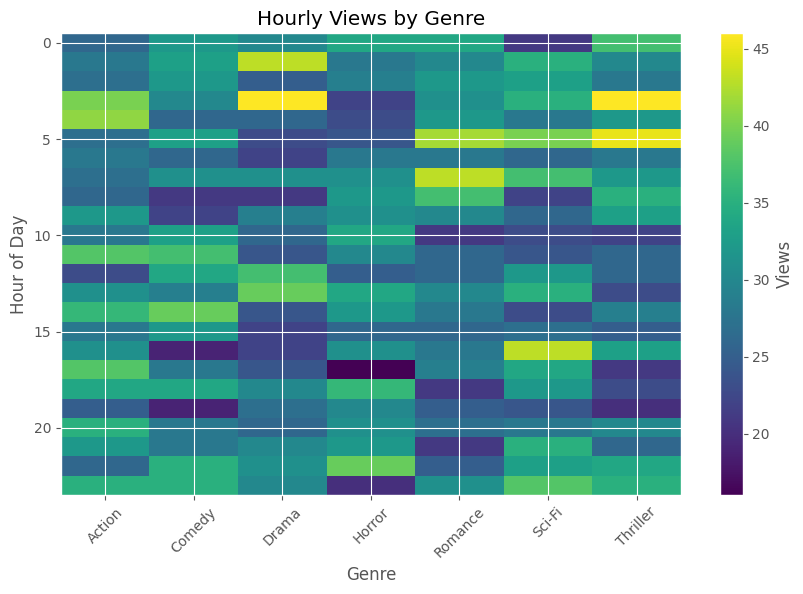

In [36]:
plt.figure(figsize=(10,6))
plt.imshow(hourly_pivot, aspect="auto")
plt.title("Hourly Views by Genre")
plt.xlabel("Genre")
plt.ylabel("Hour of Day")
plt.xticks(range(len(hourly_pivot.columns)), hourly_pivot.columns, rotation=45)
plt.colorbar(label="Views")
plt.show()


In [37]:
print("📌 Insights Summary")
print("--------------------")
print(f"Average session duration: {float(avg_session.average_session_minutes):.2f} min")

top_genre = evening_genres.iloc[0]
print(f"Peak-hour top genre: {top_genre.genre} ({top_genre.views} views)")

top_binge = binge.iloc[0]
print(f"Most binge-watched show: {top_binge.show_name} ({top_binge.binge_sessions} long sessions)")


📌 Insights Summary
--------------------
Average session duration: 47.89 min
Peak-hour top genre: Sci-Fi (158 views)
Most binge-watched show: Mindhunter (157 long sessions)


C:\Users\aryan\AppData\Local\Temp\ipykernel_16364\685271406.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Average session duration: {float(avg_session.average_session_minutes):.2f} min")


In [38]:
print("🎯 Data Observations & Recommendations")
print("• Evening hours (7 PM–12 AM) show a strong spike in overall streaming.")
print("• The top genre suggests user preference during peak times—ideal for recommendations.")
print("• Shows with high binge metrics could be candidates for targeted promotions.")
print("• Consistent long session durations hint at content stickiness.")


🎯 Data Observations & Recommendations
• Evening hours (7 PM–12 AM) show a strong spike in overall streaming.
• The top genre suggests user preference during peak times—ideal for recommendations.
• Shows with high binge metrics could be candidates for targeted promotions.
• Consistent long session durations hint at content stickiness.
